In [2]:
import json
import pickle
import re
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import svd
from scipy.stats import semicircular, gaussian_kde

In [3]:
def schatten_norm(data, p=1):
    _, s, _ = svd(data.reshape(1, -1), full_matrices=False)
    return np.sum(s**p)**(1/p)

def explained_variance_ratio(data):
    _, s, _ = svd(data, full_matrices=False)
    variance_ratio = (s**2) / np.sum(s**2)
    cumulative_variance_ratio = np.cumsum(variance_ratio)
    return variance_ratio, cumulative_variance_ratio

def plot_activation_difference_variance(baseline_diffs, at_diffs, lat_diffs, n_components=10):
    baseline_var, baseline_cum_var = explained_variance_ratio(baseline_diffs)
    at_var, at_cum_var = explained_variance_ratio(at_diffs)
    lat_var, lat_cum_var = explained_variance_ratio(lat_diffs)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Bar plot
    x = np.arange(n_components)
    width = 0.25
    
    ax1.bar(x - width, baseline_var[:n_components], width, color='tab:blue', label='Baseline Model', alpha=0.7)
    ax1.bar(x, at_var[:n_components], width, label='AT Model', color='tab:orange', alpha=0.7)
    ax1.bar(x + width, lat_var[:n_components], width, label='LAT Model', color='tab:red', alpha=0.7)
    
    ax1.set_xlabel('SVD Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Explained Variance of Activation Differences by SVD Component')
    ax1.set_xticks(x)
    ax1.set_xticklabels(range(1, n_components+1))
    ax1.legend()
    
    # Line plot
    ax2.plot(range(1, n_components+1), baseline_cum_var[:n_components], 'o-', color="tab:blue", label='Baseline Model')
    ax2.plot(range(1, n_components+1), at_cum_var[:n_components], 'o-', color="tab:orange", label='AT Model')
    ax2.plot(range(1, n_components+1), lat_cum_var[:n_components], 'o-', color="tab:red", label='LAT Model')
    ax2.set_xlabel('Number of SVD Components')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title('Cumulative Explained Variance of Activation Differences')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Explained variance at SVD component 1:")
    print(f"Baseline Model: {baseline_var[0]:.4f}")
    print(f"AT Model: {at_var[0]:.4f}")
    print(f"LAT Model: {lat_var[0]:.4f}")

    # Calculate total variance explained by top 10 components
    total_var_baseline = np.sum(baseline_var[:n_components])
    total_var_at = np.sum(at_var[:n_components])
    total_var_lat = np.sum(lat_var[:n_components])

    print(f"\nTotal variance explained by top {n_components} components:")
    print(f"Baseline Model: {total_var_baseline:.4f}")
    print(f"AT Model: {total_var_at:.4f}")
    print(f"LAT Model: {total_var_lat:.4f}")

In [4]:
with open('../data_store/results_layers_base.pkl', 'rb') as fr:
    base_results = pickle.load(fr)

with open('../data_store/results_layers_lat.pkl', 'rb') as fr:
    lat_results = pickle.load(fr)

with open('../data_store/results_layers_at.pkl', 'rb') as fr:
    at_results = pickle.load(fr)

/home/paperspace/virtualenv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [5]:
base_results_best_layer = base_results[13]
print(base_results_best_layer['run_id'])
base_harmful_acts = base_results_best_layer['harmful_acts'].cpu()
base_harmless_acts = base_results_best_layer['harmless_acts'].cpu()
base_norm_refusal_dir = base_results_best_layer['refusal_dir'].cpu()
base_unnorm_refusal_dir = (base_harmful_acts.mean(dim=0) - base_harmless_acts.mean(dim=0)).cpu()

base_diffs = base_harmful_acts - base_harmless_acts

base_n_samples_416.layer_14


In [6]:
at_results_best_layer = at_results[13]
print(at_results_best_layer['run_id'])
at_harmful_acts = at_results_best_layer['harmful_acts'].cpu()
at_harmless_acts = at_results_best_layer['harmless_acts'].cpu()
at_norm_refusal_dir = at_results_best_layer['refusal_dir'].cpu()
at_unnorm_refusal_dir = (at_harmful_acts.mean(dim=0) - at_harmless_acts.mean(dim=0)).cpu()

at_diffs = at_harmful_acts - at_harmless_acts

at_n_samples_416.layer_14


In [7]:
lat_results_best_layer = lat_results[13]
print(lat_results_best_layer['run_id'])
lat_harmful_acts = lat_results_best_layer['harmful_acts'].cpu()
lat_harmless_acts = lat_results_best_layer['harmless_acts'].cpu()
lat_norm_refusal_dir = lat_results_best_layer['refusal_dir'].cpu()
lat_unnorm_refusal_dir = (lat_harmful_acts.mean(dim=0) - lat_harmless_acts.mean(dim=0)).cpu()

lat_diffs = lat_harmful_acts - lat_harmless_acts

lat_n_samples_416.layer_14


In [13]:
print("Activation Differences")
print(f"[BASE] Schatten norm (p=1): {schatten_norm(base_diffs):.4f}")
print(f"[AT]   Schatten norm (p=1): {schatten_norm(at_diffs):.4f}")
print(f"[LAT]  Schatten norm (p=1): {schatten_norm(lat_diffs):.4f}")


Activation Differences
[BASE] Schatten norm (p=1): 376.1108
[AT]   Schatten norm (p=1): 353.0620
[LAT]  Schatten norm (p=1): 521.0562


In [8]:
print("Normalised Refusal Vector")
print(f"[BASE] Schatten norm (p=1): {schatten_norm(base_norm_refusal_dir):.4f}")
print(f"[AT]   Schatten norm (p=1): {schatten_norm(at_norm_refusal_dir):.4f}")
print(f"[LAT]  Schatten norm (p=1): {schatten_norm(lat_norm_refusal_dir):.4f}")

print()

print("Unnoormalised Refusal Vector")
print(f"[BASE] Schatten norm (p=1): {schatten_norm(base_unnorm_refusal_dir):.4f}")
print(f"[AT]   Schatten norm (p=1): {schatten_norm(at_unnorm_refusal_dir):.4f}")
print(f"[LAT]  Schatten norm (p=1): {schatten_norm(lat_unnorm_refusal_dir):.4f}")

Normalised Refusal Vector
[BASE] Schatten norm (p=1): 0.9999
[AT]   Schatten norm (p=1): 1.0000
[LAT]  Schatten norm (p=1): 1.0001

Unnoormalised Refusal Vector
[BASE] Schatten norm (p=1): 12.7403
[AT]   Schatten norm (p=1): 11.2264
[LAT]  Schatten norm (p=1): 11.5321


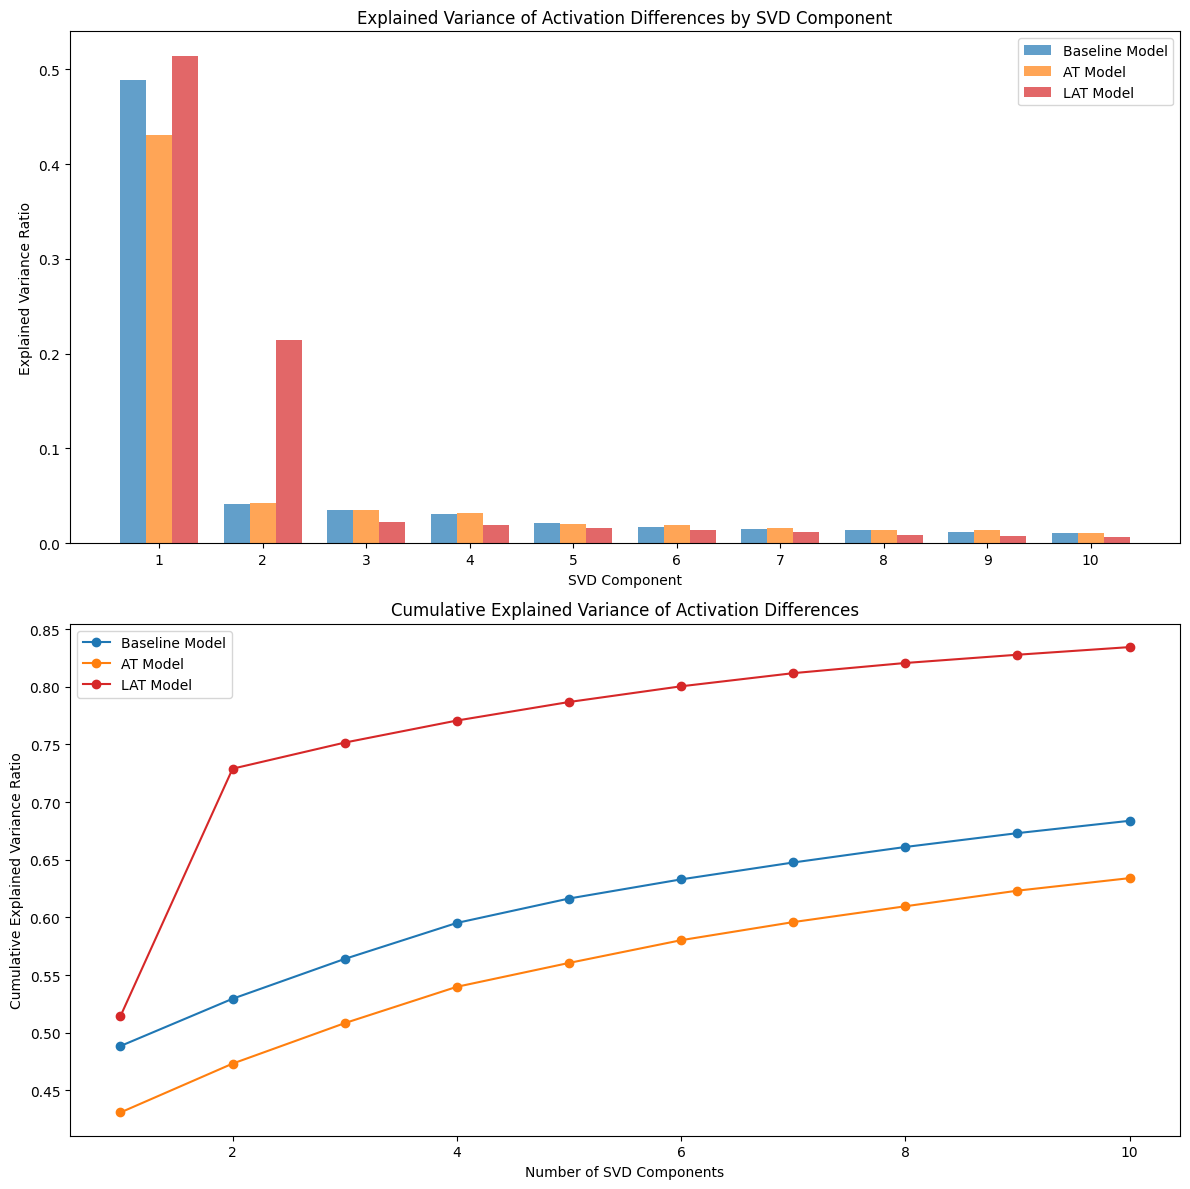

Explained variance at SVD component 1:
Baseline Model: 0.4885
AT Model: 0.4309
LAT Model: 0.5144

Total variance explained by top 10 components:
Baseline Model: 0.6837
AT Model: 0.6340
LAT Model: 0.8343


In [9]:
plot_activation_difference_variance(base_diffs, at_diffs, lat_diffs)

In [10]:
def singular_value_distribution(data):
    _, s, _ = svd(data, full_matrices=False)
    return s / np.sqrt(np.sum(s**2))  # Normalize singular values

def wigner_semicircle(x, R):
    return np.sqrt(R**2 - x**2) / (np.pi * R**2)

def marchenko_pastur(x, y):
    lambda_plus = (1 + np.sqrt(y))**2
    lambda_minus = (1 - np.sqrt(y))**2
    return np.sqrt((lambda_plus - x) * (x - lambda_minus)) / (2 * np.pi * y * x)

def create_noisy_copies(vector, n_copies, noise_level):
    return vector + noise_level * np.random.randn(n_copies, len(vector))

def plot_distributions(actual_sv, noisy_sv, n, p):
    plt.figure(figsize=(12, 6))
    
    # Actual data
    kde = gaussian_kde(actual_sv)
    x_range = np.linspace(0, max(actual_sv), 1000)
    plt.plot(x_range, kde(x_range), label='Actual Data')
    
    # Noisy copies
    kde_noisy = gaussian_kde(noisy_sv)
    plt.plot(x_range, kde_noisy(x_range), label='Noisy Copies')
    
    # Wigner's semicircle
    R = np.sqrt(2)  # For normalized singular values
    plt.plot(x_range, wigner_semicircle(x_range, R), label="Wigner's Semicircle")
    
    # Marchenko-Pastur
    y = n / p
    valid_range = x_range[(x_range >= (1 - np.sqrt(y))**2) & (x_range <= (1 + np.sqrt(y))**2)]
    plt.plot(valid_range, marchenko_pastur(valid_range, y), label='Marchenko-Pastur')
    
    plt.xlabel('Normalized Singular Values')
    plt.ylabel('Density')
    plt.title('Singular Value Distribution Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

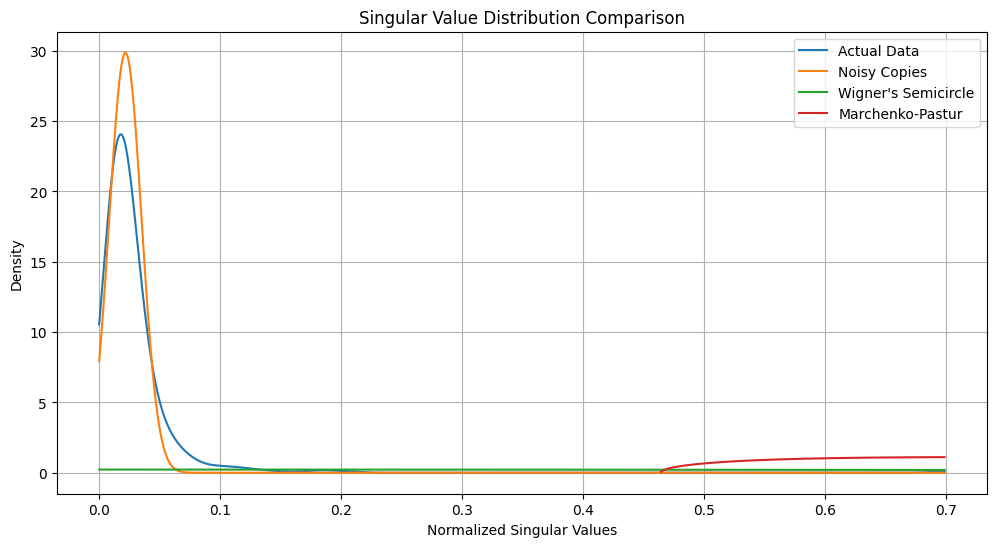

In [11]:
actual_sv = singular_value_distribution(base_diffs)

noisy_copies = create_noisy_copies(base_unnorm_refusal_dir, base_diffs.shape[0], 0.1)
noisy_sv = singular_value_distribution(noisy_copies)

# Plot distributions
n, p = base_diffs.shape
plot_distributions(actual_sv, noisy_sv, n, p)

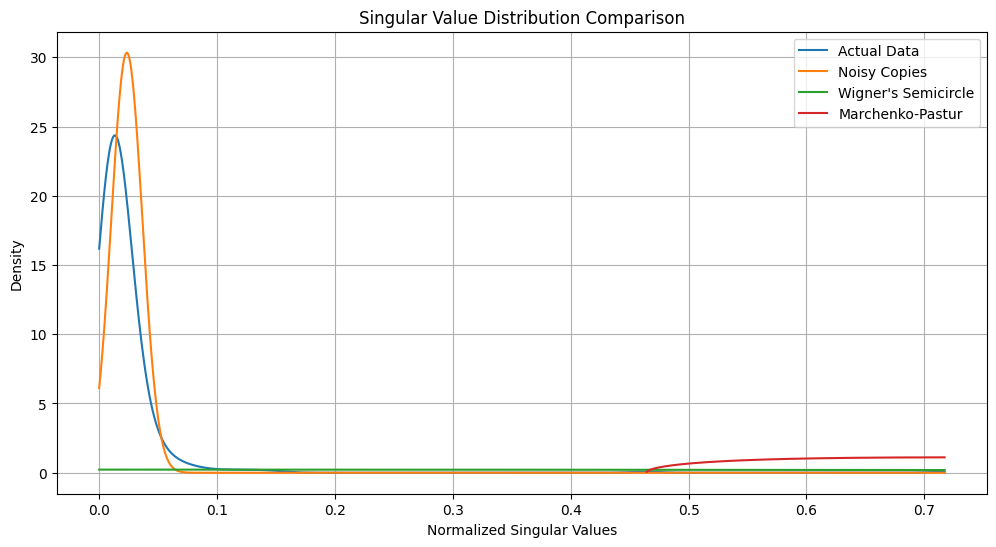

In [12]:
actual_sv = singular_value_distribution(lat_diffs)

noisy_copies = create_noisy_copies(lat_unnorm_refusal_dir, lat_diffs.shape[0], 0.1)
noisy_sv = singular_value_distribution(noisy_copies)

# Plot distributions
n, p = lat_diffs.shape
plot_distributions(actual_sv, noisy_sv, n, p)